 <!-- SVM, Small VGG Network, ArcFace, FCapNetwork -->

In [21]:
import os
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


image_size = (120, 160)
input_shape = (120, 160, 1)
n_classes = 2  # Alcohol/No Alcohol
capsule_dim = 8
routing_iterations = 3
reconstruction_error = 0.0005

dataset_path = "data"

print('Our dataset = ')
print(os.listdir(dataset_path))

Our dataset = 
['Grupo_0', 'Grupo_1', '.DS_Store', 'Grupo_4', 'Grupo_3', 'Grupo_2', 'Grupo_5']


Step 1: Loading DataSet, LG Folder - 29 Subjects, with one corrupt sample

In [22]:
def load_images_from_folder(folder_path, max_depth=5):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    for root, dirs, files in os.walk(folder_path):
        current_depth = root[len(folder_path):].count(os.sep)

        if ('IriTech' in root) or ('Iritech' in root) or ('iriTech' in root) or ('iritech' in root):
            continue

        if current_depth <= max_depth:
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    img_path = os.path.join(root, file)
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            img = cv2.resize(img, image_size)
                            images.append(img)
                            # Binary label, '0' means Fit for Duty, others alcoholic
                            labels.append(file[6] != '0')
                            names.append(file)
                    except:
                        corruptedFiles.append(img_path)
        else:
            del dirs[:]

    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")
    return np.array(images), np.array(labels), np.array(names)

images, labels, names = load_images_from_folder(dataset_path)
print(f"Read {len(images)} images from the data folder with shape {images.shape}")


Following 0 files are corrupt or encountered error: 
 []
Read 2820 images from the data folder with shape (2820, 160, 120, 3)


Randome index: 2198


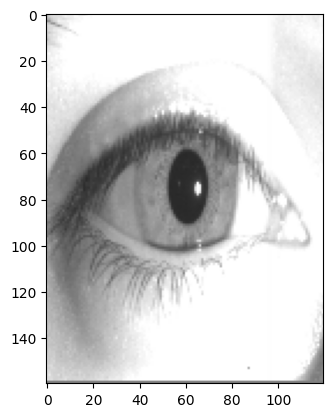

In [23]:
ri = random.randint(0, len(images) - 1)
print("Randome index: " + str(ri))
plt.imshow(images[ri])

In [ ]:
def build_conv_block(input_shape):
    model = models.Sequential([
        layers.Conv2D(256, (3, 3), activation='relu', input_shape=input_shape),
        layers.Conv2D(512, (3, 3), strides=(2, 2), activation='relu'),
        layers.Conv2D(1024, (3, 3), activation='relu'),
        layers.Flatten()  # Flatten the feature maps to prepare for the Capsule layer
    ])
    return model

# Capsule Layer
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, capsule_dim, routing_iterations, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.capsule_dim = capsule_dim
        self.routing_iterations = routing_iterations
    
    def build(self, input_shape):
        self.W = self.add_weight(shape=[self.num_capsules, input_shape[-1], self.capsule_dim],
                                 initializer='glorot_uniform',
                                 trainable=True)
    
    def call(self, inputs):
        # Reshape inputs for capsule multiplication
        inputs = tf.expand_dims(inputs, axis=1)  # Add capsule dimension (to match W)
        
        # Capsule multiplication
        u_hat = tf.matmul(inputs, self.W)  # Multiply input with capsule weights
        
        b = tf.zeros(shape=[1, self.num_capsules, 1, 1])
        
        for i in range(self.routing_iterations):
            c = tf.nn.softmax(b, axis=1)
            s = tf.reduce_sum(c * u_hat, axis=2, keepdims=True)
            v = squash(s)
            if i < self.routing_iterations - 1:
                b += tf.matmul(u_hat, v, transpose_a=True)
        
        return tf.squeeze(v, axis=2)

# Squash function for Capsule output
def squash(s):
    mag_sq = tf.reduce_sum(tf.square(s), axis=-1, keepdims=True)
    mag = tf.sqrt(mag_sq + tf.keras.backend.epsilon())
    return (mag_sq / (1.0 + mag_sq)) * (s / mag)

# Decoder to reconstruct original iris image
def build_decoder(input_dim):
    decoder = models.Sequential([
        layers.Dense(512, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(input_dim, activation='sigmoid'),
        layers.Reshape(target_shape=(120, 160, 1))
    ])
    return decoder

# Main Fusion CapsNet architecture
def build_fusion_capsnet():
    alcohol_input = layers.Input(shape=input_shape)
    no_alcohol_input = layers.Input(shape=input_shape)

    alcohol_features = build_conv_block(input_shape)(alcohol_input)
    no_alcohol_features = build_conv_block(input_shape)(no_alcohol_input)

    merged_features = layers.Concatenate()([alcohol_features, no_alcohol_features])

    reshaped_features = layers.Reshape((-1, merged_features.shape[-1]))(merged_features)  # Flatten spatial dims

    caps_output = CapsuleLayer(num_capsules=8, capsule_dim=capsule_dim, routing_iterations=routing_iterations)(reshaped_features)

    caps_output_flat = layers.Flatten()(caps_output)

    decoder = build_decoder(19200)
    reconstructed_output = decoder(caps_output_flat)

    class_output = layers.Dense(n_classes, activation='softmax')(caps_output_flat)

    model = models.Model(inputs=[alcohol_input, no_alcohol_input], outputs=[class_output, reconstructed_output])
    return model

In [25]:
#Splitting Classes
alcoholicClass = [images[i] for i in range(len(labels)) if labels[i] == 1]
nonAlcoholicClass = [images[i] for i in range(len(labels)) if labels[i] == 0]

alcClass = np.array(alcoholicClass)
ffdClass = np.array(nonAlcoholicClass)

alcLabels = np.ones(len(alcoholicClass))
ffdLabels = np.zeros(len(nonAlcoholicClass))

In [28]:
# Split the dataset into 70% train and 30% test
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=42)
images_alc_train, images_alc_test, labels_alc_train, labels_alc_test = train_test_split(
    alcClass, alcLabels, test_size=0.3, random_state=42
)
images_ffd_train, images_ffd_test, labels_ffd_train, labels_ffd_test = train_test_split(
    ffdClass, ffdLabels, test_size=0.3, random_state=42
)
# Normalize the image data
images_train = images_train / 255.0
images_test = images_test / 255.0


labels_train_cnn = to_categorical(labels_train, num_classes=2)
labels_test_cnn = to_categorical(labels_test, num_classes=2)

In [29]:
fusion_capsnet = build_fusion_capsnet()
fusion_capsnet.compile(optimizer='adam', 
                       loss=['categorical_crossentropy', 'mse'], 
                       loss_weights=[1, reconstruction_error],
                       metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
print(f"Train images count: {len(images_train)}")
print(f"Image Shape {images_train[0].shape}")
print(f"Test images count: {len(images_test)}")

Train images count: 1974
Image Shape (160, 120, 3)
Test images count: 846


In [31]:
fusion_capsnet.fit(
    [images_alc_train, images_ffd_train],
    [labels_train_cnn, images_train],
    epochs=10,
    validation_data=([images_alc_test, images_ffd_test], [labels_test_cnn, images_test])
)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 1568, 406
'y' sizes: 1974, 1974


In [ ]:
#Testing model
cnn_loss, cnn_accuracy = fusion_capsnet.evaluate(images_test, labels_test_cnn)
print(f"CNN Test Accuracy: {cnn_accuracy * 100:.2f}%")

In [ ]:
predictions = fusion_capsnet.predict(images_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels_test_cnn, axis=1)

report = classification_report(true_classes, predicted_classes, target_names=['Fit for Duty', 'Alcoholic'])
print(report)

accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Overall Accuracy: {accuracy * 100:.2f}%')

Demonstration

In [ ]:
totalTest = 0
correctTest = 0

In [ ]:
# testImagePath = 'images/test2.png'
# testImg = cv2.imread(testImagePath, cv2.IMREAD_GRAYSCALE)

r_in = random.randint(0, len(images) - 1)

testImg = images[r_in]
testLabel = labels[r_in]
# testImg = cv2.resize(testImg, image_size)

plt.imshow(testImg, cmap='gray')

testImg = np.expand_dims(testImg, axis=0)

print(testImg.shape)

prediction = fusion_capsnet.predict(testImg)
prediction = np.argmax(prediction[0])

totalTest +=1
correctTest += prediction==testLabel

prediction = 'Alcoholic' if prediction else 'Fit for duty'
testLabel = 'Alcoholic' if testLabel else 'Fit for duty'
plt.title(f'Name: {names[r_in]}\n\nPrediction: {prediction}\nActual: {testLabel}\n\nAccuracy: {correctTest/totalTest}')

In [ ]:
fusion_capsnet.save("./Models/ResNet50Classification/NonAugmented.keras")